In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✓ All packages imported successfully!
🚀 Starting ABUSE-ARSON LLM Analysis

🔍 DIAGNOSING JSON FILE STRUCTURE

GEMINI - Examining: Abuse-GEMINI.json
----------------------------------------------------------------------
Root type: <class 'dict'>
Number of top-level keys: 53
Sample keys: ['Chunk 1', 'Chunk 2', 'Chunk 3', 'Chunk 4', 'Chunk 5']

First key: 'Chunk 1'
First value type: <class 'dict'>
First value keys: ['frame_range', 'cot_analysis']

Sample content from first chunk:
  frame_range: 1-10...
  cot_analysis: Okay, let's analyze these video frames.

**Step 1: Direct Observations**

*   The frames show a room...

GPT - Examining: Abuse-GPT (2).json
----------------------------------------------------------------------
Root type: <class 'dict'>
Number of top-level keys: 51
Sample keys: ['Chunk 1', 'Chunk 2', 'Chunk 3', 'Chunk 4', 'Chunk 5']

First key: 'Chunk 1'
First value type: <class 'dict'>
First value keys: ['frame_range', 'cot_analysis']

Sample content from first chunk:
  fra

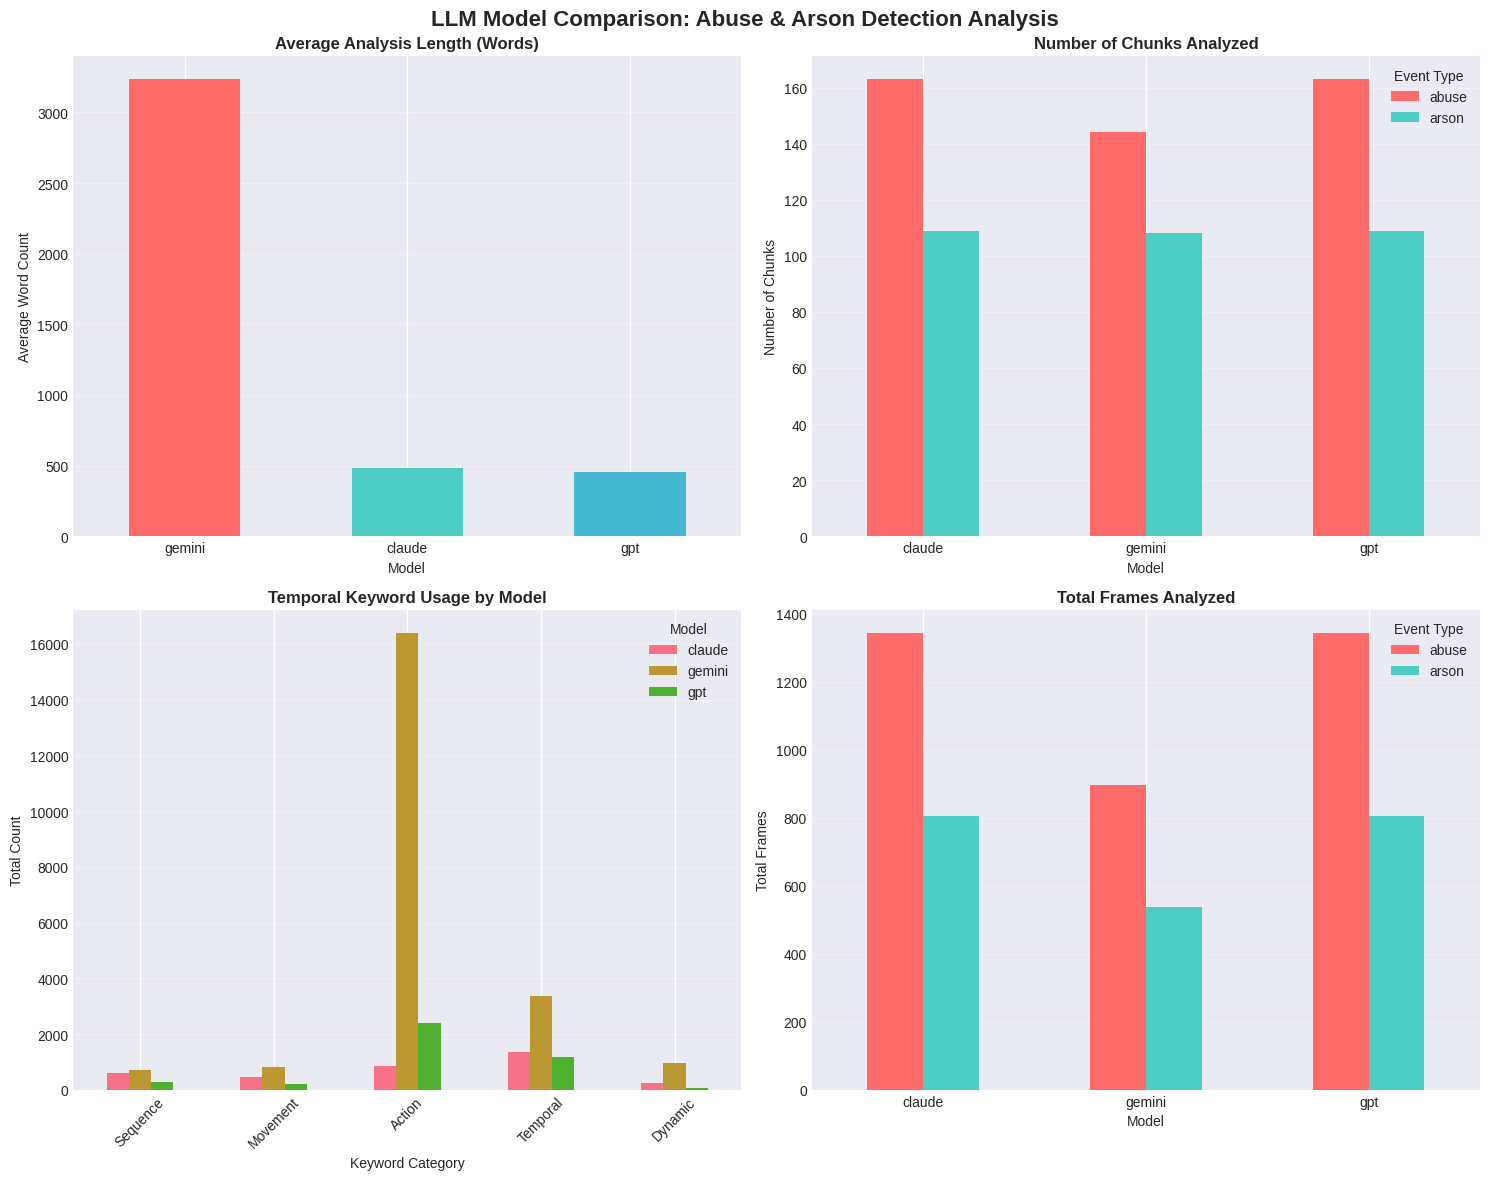

✓ Saved plot to ./temporal_analysis.png


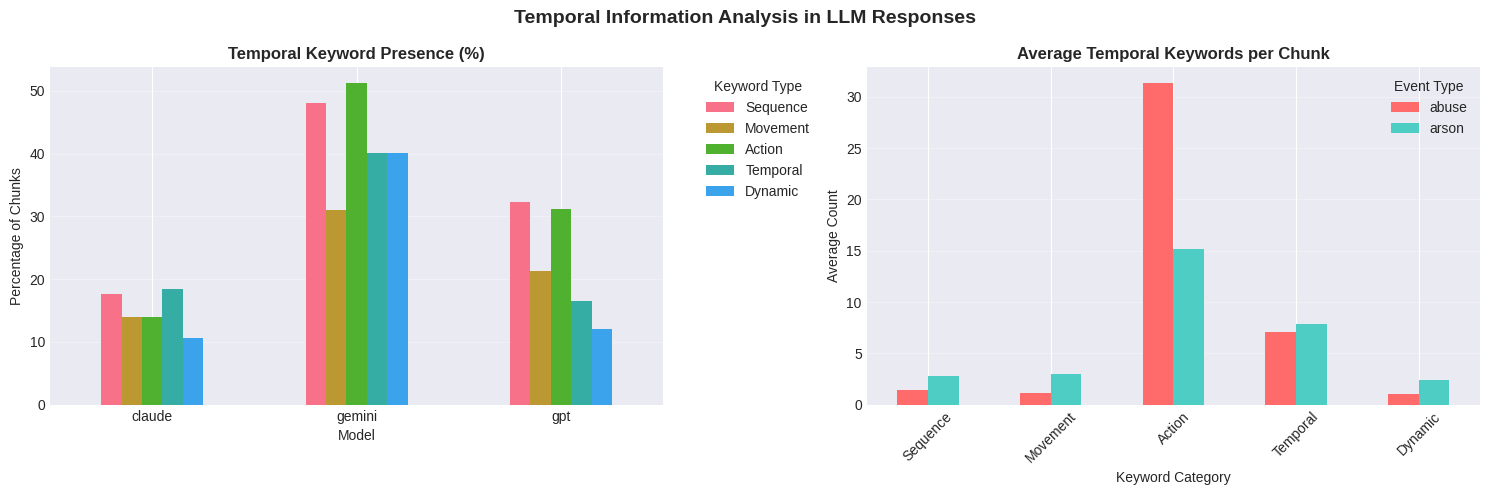


💾 Exporting results...
✓ Exported summary table
✓ Exported temporal comparison table
✓ Exported baseline comparison template
✓ Exported full analysis data
✓ Exported statistics

📁 All results exported to: ./results/

✅ ANALYSIS COMPLETE!

📁 Output files created:
  • results/summary_table.csv & .tex
  • results/temporal_comparison.csv & .tex
  • results/baseline_comparison_template.csv & .tex
  • results/full_analysis.csv
  • results/statistics.json
  • model_comparison.png
  • temporal_analysis.png

🎯 Next steps:
  1. Review the baseline_comparison_template.csv
  2. Run your video-clip baseline experiments
  3. Fill in the performance metrics
  4. Use the .tex files to include tables in your LaTeX paper


In [ ]:
"""
ABUSE-ARSON LLM Analysis: Quantitative Evaluation and Comparison
For Google Colab Environment - CORRECTED VERSION

This script analyzes LLM outputs (GPT, Gemini, Claude) for abuse and arson detection
from frame-based UCF-Crime dataset samples.
"""

# ============================================================================
# SECTION 1: SETUP AND IMPORTS
# ============================================================================

import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import re
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All packages imported successfully!")

# ============================================================================
# SECTION 2: DATA LOADING FUNCTIONS
# ============================================================================

def load_json_files(base_path: str) -> Dict[str, Dict]:
    """
    Load all JSON files from the three model directories.

    Args:
        base_path: Path to ABUSE-ARSON folder

    Returns:
        Dictionary with structure: {model: {event_type: [files]}}
    """
    data = {
        'gemini': {'abuse': [], 'arson': []},
        'gpt': {'abuse': [], 'arson': []},
        'claude': {'abuse': [], 'arson': []}
    }

    model_dirs = {
        'gemini': 'GEMINI-ABS-ARS',
        'gpt': 'GPT-ABS-ARS',
        'claude': 'CLAUDE-ABS-ARS'
    }

    for model, dir_name in model_dirs.items():
        model_path = Path(base_path) / dir_name
        if model_path.exists():
            for json_file in model_path.glob('*.json'):
                file_name = json_file.name.lower()

                # Skip macOS metadata files
                if file_name.startswith('._'):
                    continue

                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        content = json.load(f)

                        # Determine event type
                        if 'abuse' in file_name:
                            data[model]['abuse'].append({
                                'filename': json_file.name,
                                'content': content
                            })
                        elif 'arson' in file_name:
                            data[model]['arson'].append({
                                'filename': json_file.name,
                                'content': content
                            })
                except Exception as e:
                    print(f"Error loading {json_file.name}: {e}")
        else:
            print(f"Warning: Model directory not found at {model_path}")

    # Print summary
    print("\n📊 Dataset Loading Summary:")
    print("="*60)
    for model in data:
        abuse_count = len(data[model]['abuse'])
        arson_count = len(data[model]['arson'])
        total = abuse_count + arson_count
        print(f"{model.upper()}: {abuse_count} abuse files, {arson_count} arson files (Total: {total})")
    print("="*60)

    return data

# ============================================================================
# SECTION 3: ANALYSIS FUNCTIONS (CORRECTED)
# ============================================================================

def extract_chunk_info(data: Dict) -> pd.DataFrame:
    """
    Extract information about frame chunks from each JSON file.
    CORRECTED VERSION with better error handling and structure checking.

    Returns:
        DataFrame with chunk-level information
    """
    rows = []

    for model in data:
        for event_type in data[model]:
            for file_data in data[model][event_type]:
                content = file_data['content']
                filename = file_data['filename']

                # Debug: Check content structure
                if not isinstance(content, dict):
                    print(f"⚠️  Warning: {filename} content is not a dictionary (type: {type(content)})")
                    continue

                # Iterate through the JSON content
                try:
                    for chunk_key, chunk_data in content.items():
                        # Check if chunk_data is a dictionary
                        if not isinstance(chunk_data, dict):
                            print(f"⚠️  Warning: {filename} - chunk '{chunk_key}' is not a dictionary")
                            continue

                        # Extract frame range (with fallback)
                        frame_range = chunk_data.get('frame_range', '')
                        cot_analysis = chunk_data.get('cot_analysis', '')

                        # Handle missing cot_analysis
                        if not cot_analysis:
                            # Try alternative keys that might contain the analysis
                            cot_analysis = chunk_data.get('analysis', '')
                            if not cot_analysis:
                                cot_analysis = chunk_data.get('response', '')
                            if not cot_analysis:
                                cot_analysis = chunk_data.get('output', '')

                        # Parse frame range
                        start_frame, end_frame, num_frames = 0, 0, 0
                        if frame_range and '-' in str(frame_range):
                            try:
                                parts = str(frame_range).split('-')
                                start_frame = int(parts[0].strip())
                                end_frame = int(parts[1].strip())
                                num_frames = end_frame - start_frame + 1
                            except (ValueError, IndexError) as e:
                                print(f"⚠️  Warning: Could not parse frame range '{frame_range}' in {filename}")

                        # Calculate analysis length
                        analysis_length = len(str(cot_analysis))
                        analysis_words = len(str(cot_analysis).split())

                        rows.append({
                            'model': model,
                            'event_type': event_type,
                            'filename': filename,
                            'chunk': chunk_key,
                            'frame_range': frame_range,
                            'start_frame': start_frame,
                            'end_frame': end_frame,
                            'num_frames': num_frames,
                            'analysis_length_chars': analysis_length,
                            'analysis_length_words': analysis_words,
                            'cot_analysis': str(cot_analysis)
                        })

                except AttributeError as e:
                    print(f"⚠️  Error processing {filename}: {e}")
                    print(f"   Content keys: {list(content.keys())[:5] if isinstance(content, dict) else 'Not a dict'}")
                    continue

    df = pd.DataFrame(rows)
    print(f"\n✓ Extracted {len(df)} chunks from all files")

    if df.empty:
        print("\n⚠️  WARNING: No chunks were extracted!")
        print("   Please check your JSON file structure.")

    return df

def analyze_temporal_keywords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze presence of temporal-related keywords in CoT analyses.
    """
    temporal_keywords = {
        'sequence': ['sequence', 'order', 'progression', 'timeline'],
        'movement': ['movement', 'motion', 'moving', 'moves'],
        'action': ['action', 'actions', 'acting'],
        'temporal': ['before', 'after', 'during', 'then', 'next', 'following'],
        'dynamic': ['change', 'changing', 'transition', 'evolve']
    }

    # Check if DataFrame is empty before proceeding
    if df.empty:
        print("Warning: DataFrame is empty. Skipping temporal keyword analysis.")
        return df

    for category, keywords in temporal_keywords.items():
        df[f'has_{category}'] = df['cot_analysis'].apply(
            lambda x: any(kw in str(x).lower() for kw in keywords)
        )
        df[f'count_{category}'] = df['cot_analysis'].apply(
            lambda x: sum(str(x).lower().count(kw) for kw in keywords)
        )

    return df

def calculate_statistics(df: pd.DataFrame) -> Dict:
    """
    Calculate comprehensive statistics for the dataset.
    """
    stats = {}

    # Overall statistics
    stats['total_chunks'] = len(df)
    stats['total_files'] = df['filename'].nunique() if not df.empty else 0
    stats['total_frames_analyzed'] = int(df['num_frames'].sum()) if not df.empty else 0

    # Per model statistics
    stats['per_model'] = {}
    if not df.empty:
        for model in df['model'].unique():
            model_df = df[df['model'] == model]
            stats['per_model'][model] = {
                'chunks': len(model_df),
                'avg_analysis_length': float(model_df['analysis_length_words'].mean()) if not model_df.empty else 0,
                'total_frames': int(model_df['num_frames'].sum())
            }

    # Per event type statistics
    stats['per_event'] = {}
    if not df.empty:
        for event in df['event_type'].unique():
            event_df = df[df['event_type'] == event]
            stats['per_event'][event] = {
                'chunks': len(event_df),
                'files': event_df['filename'].nunique(),
                'avg_frames_per_chunk': float(event_df['num_frames'].mean()) if not event_df.empty else 0
            }

    return stats

# ============================================================================
# SECTION 4: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_model_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive comparison plots across models.
    """
    if df.empty:
        print("Warning: DataFrame is empty. Skipping model comparison plot.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LLM Model Comparison: Abuse & Arson Detection Analysis',
                 fontsize=16, fontweight='bold')

    # Plot 1: Analysis Length by Model
    ax1 = axes[0, 0]
    model_lengths = df.groupby('model')['analysis_length_words'].mean().sort_values(ascending=False)
    model_lengths.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title('Average Analysis Length (Words)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Model', fontsize=10)
    ax1.set_ylabel('Average Word Count', fontsize=10)
    ax1.tick_params(axis='x', rotation=0)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Chunks by Event Type and Model
    ax2 = axes[0, 1]
    event_model = df.groupby(['model', 'event_type']).size().unstack(fill_value=0)
    event_model.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
    ax2.set_title('Number of Chunks Analyzed', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Model', fontsize=10)
    ax2.set_ylabel('Number of Chunks', fontsize=10)
    ax2.legend(title='Event Type', loc='upper right')
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Temporal Keyword Usage
    ax3 = axes[1, 0]
    temporal_cols = [col for col in df.columns if col.startswith('count_')]
    if temporal_cols:
        temporal_data = df.groupby('model')[temporal_cols].sum()
        temporal_data.columns = [col.replace('count_', '').capitalize() for col in temporal_data.columns]
        if not temporal_data.empty:
            temporal_data.T.plot(kind='bar', ax=ax3)
            ax3.set_title('Temporal Keyword Usage by Model', fontsize=12, fontweight='bold')
            ax3.set_xlabel('Keyword Category', fontsize=10)
            ax3.set_ylabel('Total Count', fontsize=10)
            ax3.legend(title='Model', loc='upper right')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(axis='y', alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax3.transAxes)
    else:
        ax3.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax3.transAxes)

    # Plot 4: Frames Coverage
    ax4 = axes[1, 1]
    frames_by_model = df.groupby(['model', 'event_type'])['num_frames'].sum().unstack(fill_value=0)
    frames_by_model.plot(kind='bar', ax=ax4, color=['#FF6B6B', '#4ECDC4'])
    ax4.set_title('Total Frames Analyzed', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Model', fontsize=10)
    ax4.set_ylabel('Total Frames', fontsize=10)
    ax4.legend(title='Event Type', loc='upper right')
    ax4.tick_params(axis='x', rotation=0)
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot to {save_path}")

    plt.show()

def plot_temporal_analysis(df: pd.DataFrame, save_path: str = None):
    """
    Create visualizations focused on temporal information analysis.
    """
    if df.empty:
        print("Warning: DataFrame is empty. Skipping temporal analysis plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Temporal Information Analysis in LLM Responses',
                 fontsize=14, fontweight='bold')

    # Plot 1: Temporal keyword presence by model
    ax1 = axes[0]
    temporal_presence_cols = [col for col in df.columns if col.startswith('has_')]
    if temporal_presence_cols:
        temporal_presence = df.groupby('model')[temporal_presence_cols].mean() * 100
        temporal_presence.columns = [col.replace('has_', '').capitalize() for col in temporal_presence.columns]
        if not temporal_presence.empty:
            temporal_presence.plot(kind='bar', ax=ax1)
            ax1.set_title('Temporal Keyword Presence (%)', fontsize=12, fontweight='bold')
            ax1.set_xlabel('Model', fontsize=10)
            ax1.set_ylabel('Percentage of Chunks', fontsize=10)
            ax1.legend(title='Keyword Type', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.tick_params(axis='x', rotation=0)
            ax1.grid(axis='y', alpha=0.3)
        else:
            ax1.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax1.transAxes)
    else:
        ax1.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax1.transAxes)

    # Plot 2: Temporal reasoning by event type
    ax2 = axes[1]
    temporal_count_cols = [col for col in df.columns if col.startswith('count_')]
    if temporal_count_cols:
        event_temporal = df.groupby('event_type')[temporal_count_cols].mean()
        event_temporal.columns = [col.replace('count_', '').capitalize() for col in event_temporal.columns]
        if not event_temporal.empty:
            event_temporal.T.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
            ax2.set_title('Average Temporal Keywords per Chunk', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Keyword Category', fontsize=10)
            ax2.set_ylabel('Average Count', fontsize=10)
            ax2.legend(title='Event Type', loc='upper right')
            ax2.tick_params(axis='x', rotation=45)
            ax2.grid(axis='y', alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax2.transAxes)
    else:
        ax2.text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved plot to {save_path}")

    plt.show()

# ============================================================================
# SECTION 5: TABLE GENERATION FUNCTIONS
# ============================================================================

def create_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a comprehensive summary table for the paper.
    """
    if df.empty:
        print("Warning: DataFrame is empty. Returning empty summary table.")
        return pd.DataFrame()

    summary_data = []

    for model in df['model'].unique():
        model_df = df[df['model'] == model]

        for event in df['event_type'].unique():
            event_df = model_df[model_df['event_type'] == event]

            if len(event_df) > 0:
                temporal_cols = [col for col in event_df.columns if col.startswith('has_')]
                temporal_mean = event_df[temporal_cols].mean().mean() * 100 if temporal_cols and not event_df[temporal_cols].empty else 0

                summary_data.append({
                    'Model': model.upper(),
                    'Event Type': event.capitalize(),
                    'Total Files': event_df['filename'].nunique(),
                    'Total Chunks': len(event_df),
                    'Frames Analyzed': int(event_df['num_frames'].sum()),
                    'Avg Frames/Chunk': f"{event_df['num_frames'].mean():.1f}",
                    'Avg Analysis Length (words)': f"{event_df['analysis_length_words'].mean():.0f}",
                    'Temporal Keywords (%)': f"{temporal_mean:.1f}%"
                })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

def create_temporal_comparison_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a detailed table comparing temporal reasoning across models.
    """
    if df.empty:
        print("Warning: DataFrame is empty. Returning empty temporal comparison table.")
        return pd.DataFrame()

    temporal_cols = [col for col in df.columns if col.startswith('count_')]

    if not temporal_cols:
        print("Warning: No temporal columns found.")
        return pd.DataFrame()

    comparison_data = []

    for model in df['model'].unique():
        model_df = df[df['model'] == model]

        row = {'Model': model.upper()}

        for col in temporal_cols:
            keyword_type = col.replace('count_', '').capitalize()
            total_count = int(model_df[col].sum())
            avg_per_chunk = model_df[col].mean() if len(model_df) > 0 else 0
            presence_pct = (model_df[col] > 0).mean() * 100 if len(model_df) > 0 else 0

            row[f'{keyword_type} (Total)'] = total_count
            row[f'{keyword_type} (Avg/Chunk)'] = f"{avg_per_chunk:.2f}"
            row[f'{keyword_type} (% Presence)'] = f"{presence_pct:.1f}%"

        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

def create_performance_baseline_table() -> pd.DataFrame:
    """
    Create a template table for frame-based vs video-clip baseline comparison.
    NOTE: You need to fill in actual performance values based on your evaluation.
    """
    baseline_data = [
        {
            'Approach': 'Frame-Based (Current)',
            'Sampling Rate': '1 fps',
            'Accuracy (%)': 'XX.X',
            'Precision (%)': 'XX.X',
            'Recall (%)': 'XX.X',
            'F1-Score (%)': 'XX.X',
            'Processing Time (s/video)': 'X.X',
            'Memory Usage (GB)': 'X.X'
        },
        {
            'Approach': 'Video-Clip Baseline (3-sec clips)',
            'Sampling Rate': 'Full motion',
            'Accuracy (%)': 'XX.X',
            'Precision (%)': 'XX.X',
            'Recall (%)': 'XX.X',
            'F1-Score (%)': 'XX.X',
            'Processing Time (s/video)': 'X.X',
            'Memory Usage (GB)': 'X.X'
        },
        {
            'Approach': 'Performance Gap',
            'Sampling Rate': '-',
            'Accuracy (%)': '±X.X',
            'Precision (%)': '±X.X',
            'Recall (%)': '±X.X',
            'F1-Score (%)': '±X.X',
            'Processing Time (s/video)': 'X.Xx faster',
            'Memory Usage (GB)': 'X.Xx less'
        }
    ]

    baseline_df = pd.DataFrame(baseline_data)
    return baseline_df

# ============================================================================
# SECTION 6: EXPORT FUNCTIONS
# ============================================================================

def export_all_results(df: pd.DataFrame, stats: Dict, output_dir: str = './results'):
    """
    Export all analysis results to files.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Export summary table
    summary_table = create_summary_table(df)
    if not summary_table.empty:
        summary_table.to_csv(f'{output_dir}/summary_table.csv', index=False)
        summary_table.to_latex(f'{output_dir}/summary_table.tex', index=False)
        print(f"✓ Exported summary table")
    else:
        print("Warning: Summary table is empty. Skipping export.")

    # Export temporal comparison table
    temporal_table = create_temporal_comparison_table(df)
    if not temporal_table.empty:
        temporal_table.to_csv(f'{output_dir}/temporal_comparison.csv', index=False)
        temporal_table.to_latex(f'{output_dir}/temporal_comparison.tex', index=False)
        print(f"✓ Exported temporal comparison table")
    else:
        print("Warning: Temporal comparison table is empty. Skipping export.")

    # Export baseline comparison template
    baseline_table = create_performance_baseline_table()
    baseline_table.to_csv(f'{output_dir}/baseline_comparison_template.csv', index=False)
    baseline_table.to_latex(f'{output_dir}/baseline_comparison_template.tex', index=False)
    print(f"✓ Exported baseline comparison template")

    # Export full dataframe
    if not df.empty:
        df.to_csv(f'{output_dir}/full_analysis.csv', index=False)
        print(f"✓ Exported full analysis data")
    else:
        print("Warning: Full analysis dataframe is empty. Skipping export.")

    # Export statistics as JSON
    if stats:
        with open(f'{output_dir}/statistics.json', 'w') as f:
            json.dump(stats, f, indent=2)
        print(f"✓ Exported statistics")
    else:
        print("Warning: Statistics dictionary is empty. Skipping export.")

    print(f"\n📁 All results exported to: {output_dir}/")

def print_statistics_summary(stats: Dict):
    """
    Print a formatted summary of statistics.
    """
    if not stats:
        print("\nWarning: Statistics are empty. Skipping statistics summary print.")
        return

    print("\n" + "="*70)
    print("📈 COMPREHENSIVE STATISTICS SUMMARY")
    print("="*70)

    print(f"\n🔢 Overall Statistics:")
    print(f"  • Total chunks analyzed: {stats.get('total_chunks', 0):,}")
    print(f"  • Total files processed: {stats.get('total_files', 0)}")
    print(f"  • Total frames analyzed: {stats.get('total_frames_analyzed', 0):,}")

    print(f"\n🤖 Per-Model Statistics:")
    if 'per_model' in stats:
        for model, data in stats['per_model'].items():
            print(f"  {model.upper()}:")
            print(f"    - Chunks: {data.get('chunks', 0):,}")
            print(f"    - Avg analysis length: {data.get('avg_analysis_length', 0):.1f} words")
            print(f"    - Total frames: {data.get('total_frames', 0):,}")
    else:
        print("  No per-model statistics available.")

    print(f"\n🎯 Per-Event Statistics:")
    if 'per_event' in stats:
        for event, data in stats['per_event'].items():
            print(f"  {event.upper()}:")
            print(f"    - Chunks: {data.get('chunks', 0):,}")
            print(f"    - Files: {data.get('files', 0)}")
            print(f"    - Avg frames/chunk: {data.get('avg_frames_per_chunk', 0):.1f}")
    else:
        print("  No per-event statistics available.")

    print("="*70)

# ============================================================================
# SECTION 7: DIAGNOSTIC FUNCTION (NEW)
# ============================================================================

def diagnose_json_structure(base_path: str):
    """
    Diagnose the structure of JSON files to help debug issues.
    """
    print("\n" + "="*70)
    print("🔍 DIAGNOSING JSON FILE STRUCTURE")
    print("="*70)

    model_dirs = {
        'gemini': 'GEMINI-ABS-ARS',
        'gpt': 'GPT-ABS-ARS',
        'claude': 'CLAUDE-ABS-ARS'
    }

    for model, dir_name in model_dirs.items():
        model_path = Path(base_path) / dir_name
        if model_path.exists():
            json_files = list(model_path.glob('*.json'))
            if json_files:
                sample_file = json_files[0]
                print(f"\n{model.upper()} - Examining: {sample_file.name}")
                print("-" * 70)

                try:
                    with open(sample_file, 'r', encoding='utf-8') as f:
                        content = json.load(f)

                    print(f"Root type: {type(content)}")

                    if isinstance(content, dict):
                        print(f"Number of top-level keys: {len(content)}")
                        print(f"Sample keys: {list(content.keys())[:5]}")

                        # Examine first entry
                        first_key = list(content.keys())[0]
                        first_value = content[first_key]
                        print(f"\nFirst key: '{first_key}'")
                        print(f"First value type: {type(first_value)}")

                        if isinstance(first_value, dict):
                            print(f"First value keys: {list(first_value.keys())}")

                            # Show a sample of the actual content
                            print(f"\nSample content from first chunk:")
                            for k, v in list(first_value.items())[:3]:
                                print(f"  {k}: {str(v)[:100]}...")

                    elif isinstance(content, list):
                        print(f"Root is a list with {len(content)} items")
                        if content:
                            print(f"First item type: {type(content[0])}")

                except Exception as e:
                    print(f"Error examining file: {e}")

    print("\n" + "="*70)

# ============================================================================
# SECTION 8: MAIN EXECUTION (UPDATED)
# ============================================================================

def main():
    """
    Main execution function - run the complete analysis pipeline.
    """
    print("🚀 Starting ABUSE-ARSON LLM Analysis")
    print("="*70)

    # YOUR ACTUAL PATH
    BASE_PATH = '/content/drive/Shareddrives/DR KOFI RESEARCH/RESEARCH/COMPLETED/PROMPTS/ABUSE-ARSON'

    # Check if path exists
    if not os.path.exists(BASE_PATH):
        print(f"\n❌ ERROR: Path '{BASE_PATH}' not found!")
        print("   Please update BASE_PATH variable with the correct path.")
        return pd.DataFrame(), {}

    # NEW: Diagnose JSON structure first
    diagnose_json_structure(BASE_PATH)

    # STEP 1: Load data
    print(f"\n📂 Loading data from: {BASE_PATH}")
    data = load_json_files(BASE_PATH)

    # STEP 2: Extract and analyze chunks
    print("\n🔍 Extracting chunk information...")
    df = extract_chunk_info(data)

    if df.empty:
        print("\n❌ ERROR: No data was extracted!")
        print("   Please check the JSON structure diagnosis above.")
        return df, {}

    print("\n🔍 Analyzing temporal keywords...")
    df = analyze_temporal_keywords(df)

    # STEP 3: Calculate statistics
    print("\n📊 Calculating statistics...")
    stats = calculate_statistics(df)
    print_statistics_summary(stats)

    # STEP 4: Display summary tables
    print("\n" + "="*70)
    print("📋 SUMMARY TABLE (For Paper)")
    print("="*70)
    summary_table = create_summary_table(df)
    if not summary_table.empty:
        print(summary_table.to_string(index=False))

    print("\n" + "="*70)
    print("⏱️ TEMPORAL COMPARISON TABLE (For Paper)")
    print("="*70)
    temporal_table = create_temporal_comparison_table(df)
    if not temporal_table.empty:
        print(temporal_table.to_string(index=False))

    print("\n" + "="*70)
    print("📊 BASELINE COMPARISON TEMPLATE (Fill in your results)")
    print("="*70)
    baseline_table = create_performance_baseline_table()
    print(baseline_table.to_string(index=False))
    print("\n⚠️  NOTE: Replace 'XX.X' values with your actual evaluation results")

    # STEP 5: Create visualizations
    print("\n📊 Generating visualizations...")
    plot_model_comparison(df, save_path='./model_comparison.png')
    plot_temporal_analysis(df, save_path='./temporal_analysis.png')

    # STEP 6: Export results
    print("\n💾 Exporting results...")
    export_all_results(df, stats, output_dir='./results')

    print("\n" + "="*70)
    print("✅ ANALYSIS COMPLETE!")
    print("="*70)
    print("\n📁 Output files created:")
    print("  • results/summary_table.csv & .tex")
    print("  • results/temporal_comparison.csv & .tex")
    print("  • results/baseline_comparison_template.csv & .tex")
    print("  • results/full_analysis.csv")
    print("  • results/statistics.json")
    print("  • model_comparison.png")
    print("  • temporal_analysis.png")
    print("\n🎯 Next steps:")
    print("  1. Review the baseline_comparison_template.csv")
    print("  2. Run your video-clip baseline experiments")
    print("  3. Fill in the performance metrics")
    print("  4. Use the .tex files to include tables in your LaTeX paper")
    print("="*70)

    return df, stats

# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

if __name__ == "__main__":
    df, stats = main()